# RFM- Cluster

## Librerias

In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from lifetimes.utils import *

## Leer Dataset

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Prepar Datos

In [4]:
# Registros Nulos
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df = df[df['CustomerID'].notnull()]

In [8]:
# Valores negativos
df['Quantity'].min()

-80995

In [9]:
df= df[df['Quantity']>0]

In [10]:
# Conevrtir campo fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [11]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [12]:
# creat Columan Total Amount
df['total_amount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [13]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'total_amount'],
      dtype='object')

In [14]:
# Seleccionar colunas
cols = ['CustomerID', 'InvoiceDate', 'total_amount']
data = df[cols]
data.head()

,CustomerID,InvoiceDate,total_amount
0,17850.0,2010-12-01 08:26:00,15.30
1,17850.0,2010-12-01 08:26:00,20.34
2,17850.0,2010-12-01 08:26:00,22.00
3,17850.0,2010-12-01 08:26:00,20.34
4,17850.0,2010-12-01 08:26:00,20.34


### Análisis simple

In [16]:
# Cantidad de Clientes_unicos
data.CustomerID.nunique()

4339

In [17]:
# Fecha de inicio de ventas 
data.InvoiceDate.min()

Timestamp('2010-12-01 08:26:00')

In [18]:
# Ultm fecha de registro de ventas
data.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

In [20]:
# Total de ventas
data.total_amount.sum()

8911407.904

In [21]:
# Ventas max
data.total_amount.max()

168469.6

##  RFM

In [23]:
df_rfm = summary_data_from_transaction_data(data,'CustomerID', 'InvoiceDate', 
                                            monetary_value_col='total_amount', observation_period_end= '2011-12-09')

In [24]:
df_rfm.reset_index(inplace=True)
df_rfm.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000


In [25]:
#Dividir los datos en quantiles para la segmentación
quantiles = df_rfm.quantile([.25,.50,.75])
quantiles = quantiles.to_dict()
quantiles

{'CustomerID': {0.25: 13812.5, 0.5: 15299.0, 0.75: 16778.5},
 'frequency': {0.25: 0.0, 0.5: 1.0, 0.75: 3.0},
 'recency': {0.25: 0.0, 0.5: 93.0, 0.75: 252.0},
 'T': {0.25: 112.0, 0.5: 248.0, 0.75: 326.0},
 'monetary_value': {0.25: 0.0,
  0.5: 176.94000000000003,
  0.75: 360.1616666666667}}

In [36]:
# Funciones  para Categiroizar los campos en base a los quntiles
def rscoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x<= d[p][0.50]:
        return 2
    elif x<= d[p][0.75]:
        return 3
    else:
        return 4
    
def fmscoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x<= d[p][0.75]:
        return 2
    else:
        return 1

In [37]:
df_rfm['R'] = df_rfm['recency'].apply(rscoring, args=('recency', quantiles))
df_rfm['F'] = df_rfm['frequency'].apply(fmscoring, args=('frequency', quantiles))
df_rfm['M'] = df_rfm['monetary_value'].apply(fmscoring, args=('monetary_value', quantiles))

In [38]:
df_rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M
0,12346.0,0.0,0.0,325.0,0.000000,1,4,4
1,12347.0,6.0,365.0,367.0,599.701667,4,1,1
2,12348.0,3.0,283.0,358.0,301.480000,4,2,2
3,12349.0,0.0,0.0,18.0,0.000000,1,4,4
4,12350.0,0.0,0.0,310.0,0.000000,1,4,4


In [39]:
# Concatenar columnas
df_rfm['RFM'] = df_rfm.R.map(str) + df_rfm.F.map(str) + df_rfm.M.map(str)

In [40]:
# Sumar columnas
df_rfm['RFM_score'] = df_rfm.R + df_rfm.F + df_rfm.M

In [41]:
df_rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM,RFM_score
0,12346.0,0.0,0.0,325.0,0.000000,1,4,4,144,9
1,12347.0,6.0,365.0,367.0,599.701667,4,1,1,411,6
2,12348.0,3.0,283.0,358.0,301.480000,4,2,2,422,8
3,12349.0,0.0,0.0,18.0,0.000000,1,4,4,144,9
4,12350.0,0.0,0.0,310.0,0.000000,1,4,4,144,9


In [42]:
# Asignar etiquetas o segmanetacion
etiquetas = ['Platinium', 'Gold', 'Silver', 'Bronze']
df_rfm['Seg_customer'] = pd.cut(df_rfm.RFM_score, labels=etiquetas, bins=4)

In [43]:
df_rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM,RFM_score,Seg_customer
0,12346.0,0.0,0.0,325.0,0.000000,1,4,4,144,9,Bronze
1,12347.0,6.0,365.0,367.0,599.701667,4,1,1,411,6,Gold
2,12348.0,3.0,283.0,358.0,301.480000,4,2,2,422,8,Silver
3,12349.0,0.0,0.0,18.0,0.000000,1,4,4,144,9,Bronze
4,12350.0,0.0,0.0,310.0,0.000000,1,4,4,144,9,Bronze


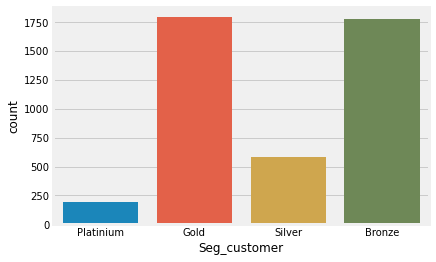

In [45]:
sns.countplot(data = df_rfm, x = 'Seg_customer');

In [46]:
# cantidad por segmento
df_rfm['Seg_customer'].value_counts()

Gold         1793
Bronze       1775
Silver        580
Platinium     191
Name: Seg_customer, dtype: int64

## Cluster-con sklearn

In [47]:
from sklearn.cluster import KMeans

In [48]:
df_rfm.columns

Index(['CustomerID', 'frequency', 'recency', 'T', 'monetary_value', 'R', 'F',
       'M', 'RFM', 'RFM_score', 'Seg_customer'],
      dtype='object')

In [49]:
# seleccionar columnas
cols = ['frequency', 'recency', 'monetary_value']
X = df_rfm[cols]
X.head()

,frequency,recency,monetary_value
0,0.0,0.0,0.000000
1,6.0,365.0,599.701667
2,3.0,283.0,301.480000
3,0.0,0.0,0.000000
4,0.0,0.0,0.000000


### Standararización de los datos

In [50]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Método del codo

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


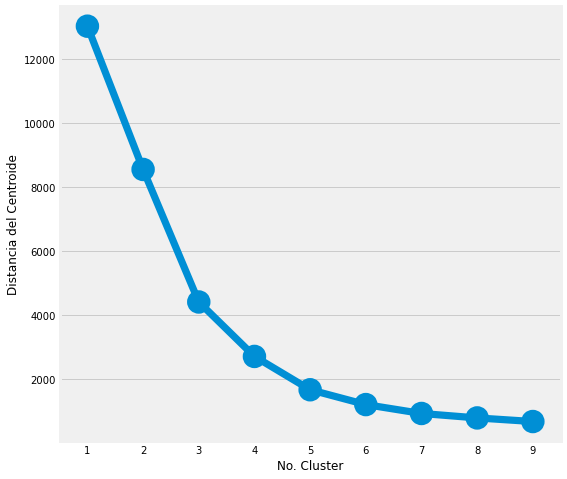

In [56]:
see = {}

for k in range(1,10):
    km = KMeans(n_clusters=k, max_iter=1000).fit(X_sc)
    X['Cluster'] = km.labels_
    see[k] = km.inertia_
plt.figure(figsize = (8,8))
sns.pointplot(list(see.keys()), list(see.values()))
plt.xlabel('No. Cluster')
plt.ylabel('Distancia del Centroide')
plt.show()

Para este dataset se puede utilizar como cluster el 3,4,5

### Con 3 Clusters

In [57]:
km3 = KMeans(n_clusters=3, max_iter=1000)
km3.fit(X_sc)

KMeans(max_iter=1000, n_clusters=3)

In [58]:
df_rfm['Cluster'] = km3.predict(X_sc)

In [59]:
df_rfm.head()

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM,RFM_score,Seg_customer,Cluster
0,12346.0,0.0,0.0,325.0,0.000000,1,4,4,144,9,Bronze,1
1,12347.0,6.0,365.0,367.0,599.701667,4,1,1,411,6,Gold,0
2,12348.0,3.0,283.0,358.0,301.480000,4,2,2,422,8,Silver,0
3,12349.0,0.0,0.0,18.0,0.000000,1,4,4,144,9,Bronze,1
4,12350.0,0.0,0.0,310.0,0.000000,1,4,4,144,9,Bronze,1


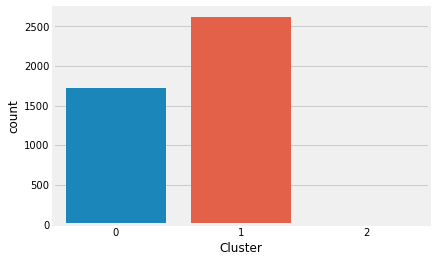

In [62]:
sns.countplot(data = df_rfm, x = 'Cluster');

In [63]:
df_rfm['Cluster'].value_counts()

1    2616
0    1722
2       1
Name: Cluster, dtype: int64

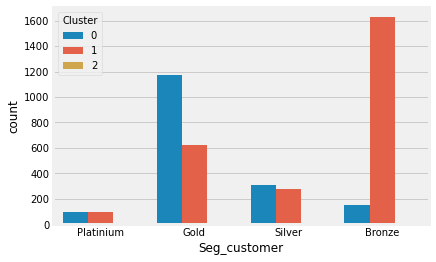

In [61]:
sns.countplot(data = df_rfm, x = 'Seg_customer', hue='Cluster');

In [76]:
df_rfm[df_rfm['Cluster']==1]

,CustomerID,frequency,recency,T,monetary_value,R,F,M,RFM,RFM_score,Seg_customer,Cluster,Clus_4,Clus_5
0,12346.0,0.0,0.0,325.0,0.00,1,4,4,144,9,Bronze,1,1,1
3,12349.0,0.0,0.0,18.0,0.00,1,4,4,144,9,Bronze,1,1,1
4,12350.0,0.0,0.0,310.0,0.00,1,4,4,144,9,Bronze,1,1,1
6,12353.0,0.0,0.0,204.0,0.00,1,4,4,144,9,Bronze,1,1,1
7,12354.0,0.0,0.0,232.0,0.00,1,4,4,144,9,Bronze,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18278.0,0.0,0.0,73.0,0.00,1,4,4,144,9,Bronze,1,1,1
4334,18280.0,0.0,0.0,277.0,0.00,1,4,4,144,9,Bronze,1,1,1
4335,18281.0,0.0,0.0,180.0,0.00,1,4,4,144,9,Bronze,1,1,1
4336,18282.0,1.0,119.0,126.0,77.84,3,3,3,333,9,Bronze,1,1,1


### cluster de 4

In [65]:
km4 = KMeans(n_clusters=4, max_iter=1000)
km4.fit(X_sc)

KMeans(max_iter=1000, n_clusters=4)

In [66]:
df_rfm['Clus_4'] = km4.predict(X_sc)

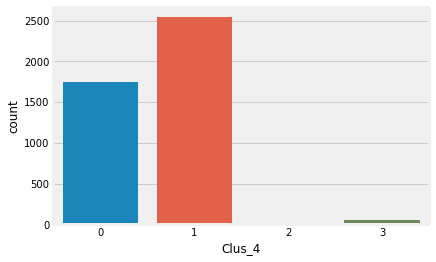

In [67]:
sns.countplot(data = df_rfm, x = 'Clus_4');

In [68]:
df_rfm['Clus_4'].value_counts()

1    2542
0    1746
3      50
2       1
Name: Clus_4, dtype: int64

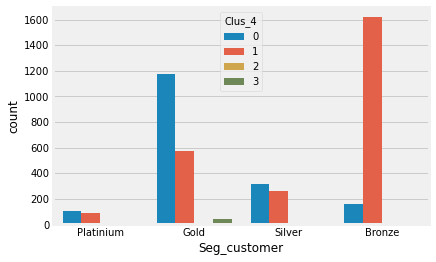

In [70]:
sns.countplot(data = df_rfm, x = 'Seg_customer', hue='Clus_4');

### Clsuert Km=5

In [71]:
km5 = KMeans(n_clusters=5, max_iter=1000).fit(X_sc)
df_rfm['Clus_5'] = km5.predict(X_sc)

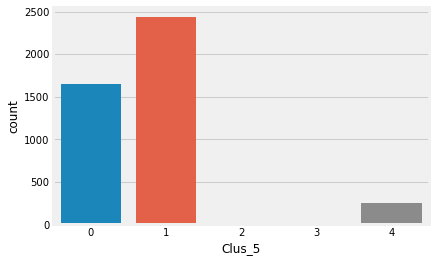

In [73]:
sns.countplot(data = df_rfm, x = 'Clus_5');

In [72]:
df_rfm.Clus_5.value_counts()

1    2433
0    1646
4     252
3       7
2       1
Name: Clus_5, dtype: int64

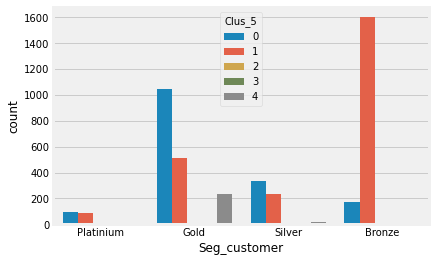

In [74]:
sns.countplot(data = df_rfm, x = 'Seg_customer', hue='Clus_5');